# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

### Checkup Exercise Set I

**Exercise:** Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):

* customer_name
* One column for each offer, with a 1 if the customer responded to the offer

Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.


In [4]:
#your turn

"""
building the desired table requires two steps:
1. merge two data tables into a single dataframe with offer-customer observations
2. pivot this table to create the desired output table
"""

# merge using left join to create mid-stage dataframe
offer_customers = df_offers.merge(df_transactions, how = 'left', left_on = 'offer_id', right_on = 'offer_id')
offer_customers.head()

offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  
0        Thomas  1  
1       Jackson  1  
2      Mitchell  1  
3      Peterson  1  
4          Wood  1

In [5]:
# pivot table to transform to customer_names with response to offers
customer_offer = pd.pivot_table(offer_customers, values = 'n', index = ['customer_name'], columns = ['offer_id'], fill_value = 0)

# move index (customer names) into dataframe as first column and reset index
customer_offer.reset_index(inplace = True)

print("variables: %s" % str(customer_offer.shape[1]))
print("observations: %s" % str(customer_offer.shape[0]))

customer_offer.head(n = 10)

variables: 33
observations: 100


offer_id customer_name  1  2  3  4  5  6  7  8  9 ...  23  24  25  26  27  28  \
0                Adams  0  0  0  0  0  0  0  0  0 ...   0   0   0   0   0   0   
1                Allen  0  0  0  0  0  0  0  0  1 ...   0   0   0   0   1   0   
2             Anderson  0  0  0  0  0  0  0  0  0 ...   0   1   0   1   0   0   
3               Bailey  0  0  0  0  0  0  1  0  0 ...   0   0   0   0   0   0   
4                Baker  0  0  0  0  0  0  1  0  0 ...   0   0   0   0   0   0   
5               Barnes  0  0  0  0  0  0  0  0  0 ...   0   0   0   0   0   0   
6                 Bell  0  1  0  0  0  0  0  0  0 ...   0   1   0   1   0   0   
7              Bennett  0  0  0  0  0  0  0  1  0 ...   0   0   0   0   0   0   
8               Brooks  0  0  1  0  0  0  0  1  0 ...   0   0   0   0   0   0   
9                Brown  0  0  0  0  0  0  1  0  0 ...   0   0   0   0   0   0   

offer_id  29  30  31  32  
0          1   1   0   0  
1          0   0   0   0  
2          0   0   0   0  
3          0   1   0   0  
4          0   0   1   0  
5          0   0   1   0  
6          0   0   0   0  
7          1   0   0   0  
8          0   0   0   0  
9          1   1   0   0  

[10 rows x 33 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method and the Silhouette method, as well as the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

### Checkup Exercise Set II

**Exercise:**

* What values of $SS$ do you believe represent better clusterings? Why?
* Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
* Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
* Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
* Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
* What challenges did you experience using the Elbow method to pick $K$?

_Reply:_ The lower the value of $SS$, the better the clustering. $SS$ measures the squared distance from the centroid, as indicated in both the text and equation above. Reducing $SS$ represents a reduction in the distance from nodes to centroids across all clusters. Since $SS$ is the measure of the error in the clustering, then the best clusterings will minimize that error. But, always seeking lower values of $SS$ will produce overfitting; the best measurement will be when each observation has exactly its own cluster. This is, of course, a useless result. The best result seek the fewest number of clusters necessary while still minimzing $SS$.


In [6]:
# your turn

# generate the numpy matrix
import numpy as np
x_cols = np.matrix(customer_offer.iloc[:,2:33])
print(type(x_cols))
x_cols

<class 'numpy.matrixlib.defmatrix.matrix'>


matrix([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

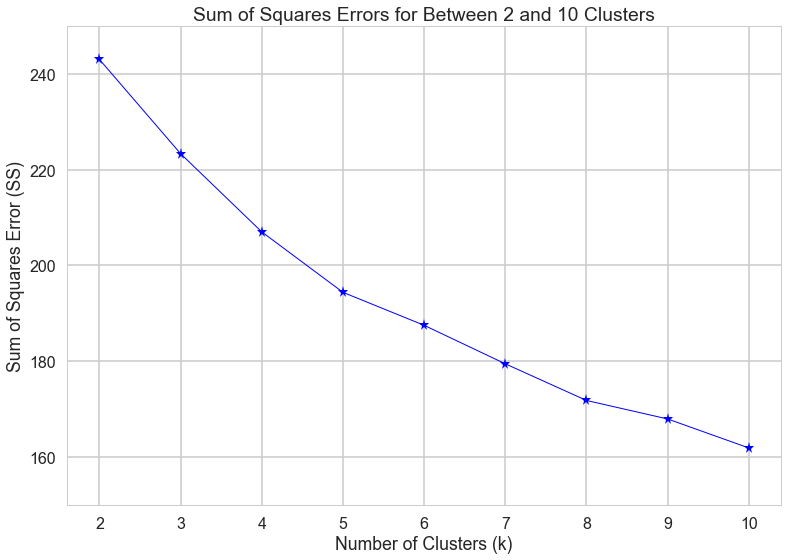

In [7]:
from sklearn.cluster import KMeans

# setup a range of possible k values; 2 <= k <= 10
k_range = range(2,11)

# obtain a list that has the SS value for each k
kmeans_ss = [KMeans( n_clusters = k, random_state = 5 ).fit(x_cols).inertia_ for k in k_range]

# make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, kmeans_ss, 'b*-', linewidth = 1.0)
ax.set_ylim((150, 250))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squares Error (SS)')
plt.title('Sum of Squares Errors for Between 2 and 10 Clusters')

No clear best cluster really emerges under this method for this data. Perhaps the best option is at 8 clusters, which appears to have the clearest transition from steep to flat gains. But, even without looking at the bar chart to come, I expect that there will be very few observations per cluster; there are only 100 observations to begin with, and with 8 clusters, we can expect a little over 10 observations per cluster. This is a very low number of observations for any unsupervised learning method.

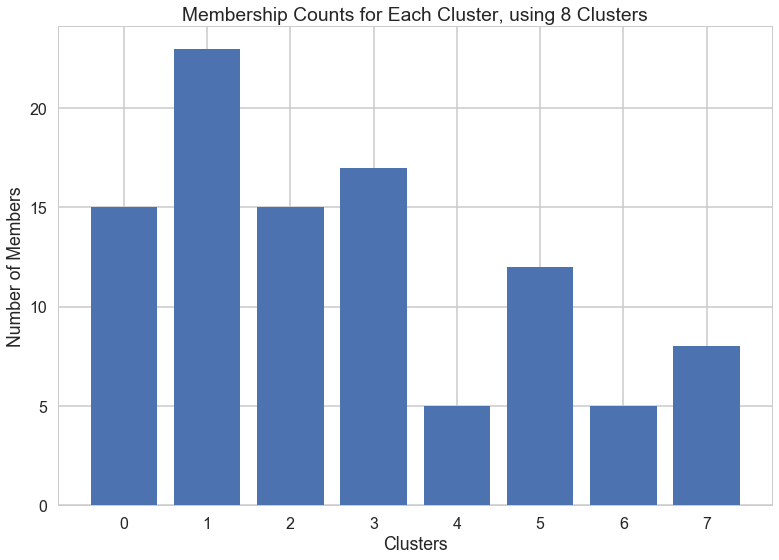

In [8]:
# count membership using k = 8

# extract counts of cluster membership
best_k = 8
best_k_clusters = KMeans(n_clusters = best_k, random_state = 5)
customer_offer['cluster'] = best_k_clusters.fit_predict(np.matrix(customer_offer.iloc[:,2:33]))

# transform counts into dataframe for easier graphing
counts = pd.DataFrame(customer_offer.cluster.value_counts())
counts.columns = ['count']
counts['cluster'] = counts.index

# plot the membership each cluster
plt.bar(list(counts['cluster']),list(counts['count']))
plt.xlabel('Clusters')
plt.ylabel('Number of Members')
plt.title('Membership Counts for Each Cluster, using 8 Clusters')

As expected, the clusters are rather small, and likely not a good representation of the data at hand. The Elbow Method, at least in small datasets, clearly has some shortcomings. In this case it appears to have badly overfit the data. Another option, based on the plot is to use five clusters. Let's repeat the process with that value for $k$.

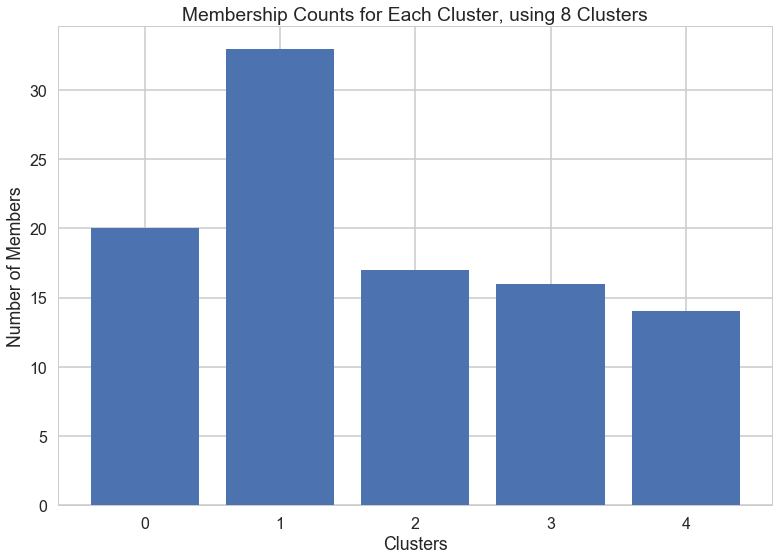

In [9]:
# repeat using k = 5

# extract counts of cluster membership
best_k = 5
best_k_clusters = KMeans(n_clusters = best_k, random_state = 5)
customer_offer['cluster'] = best_k_clusters.fit_predict(np.matrix(customer_offer.iloc[:,2:33]))

# transform counts into dataframe for easier graphing
counts = pd.DataFrame(customer_offer.cluster.value_counts())
counts.columns = ['count']
counts['cluster'] = counts.index

# plot the membership each cluster
plt.bar(list(counts['cluster']),list(counts['count']))
plt.xlabel('Clusters')
plt.ylabel('Number of Members')
plt.title('Membership Counts for Each Cluster, using 8 Clusters')

This result does appear to be somewhat better. Still, without a clear kink in the figure, it's difficult to get a good indication of how many clusters should be sought.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

### Checkup Exercise Set III

**Exercise:** Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.

**Exercise:** Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

For k = 2, the average silhouette score is 0.0947
For k = 3, the average silhouette score is 0.1042
For k = 4, the average silhouette score is 0.1333
For k = 5, the average silhouette score is 0.1495
For k = 6, the average silhouette score is 0.1388
For k = 7, the average silhouette score is 0.1266
For k = 8, the average silhouette score is 0.1300
For k = 9, the average silhouette score is 0.1266
For k = 10, the average silhouette score is 0.1226


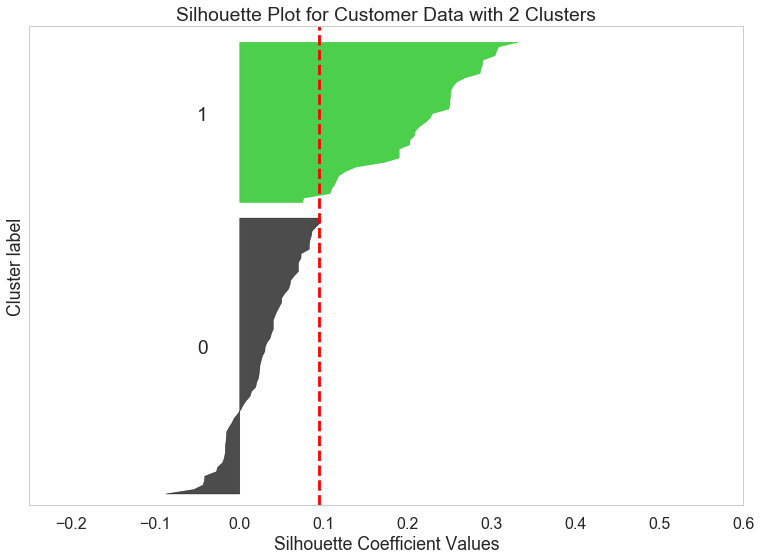

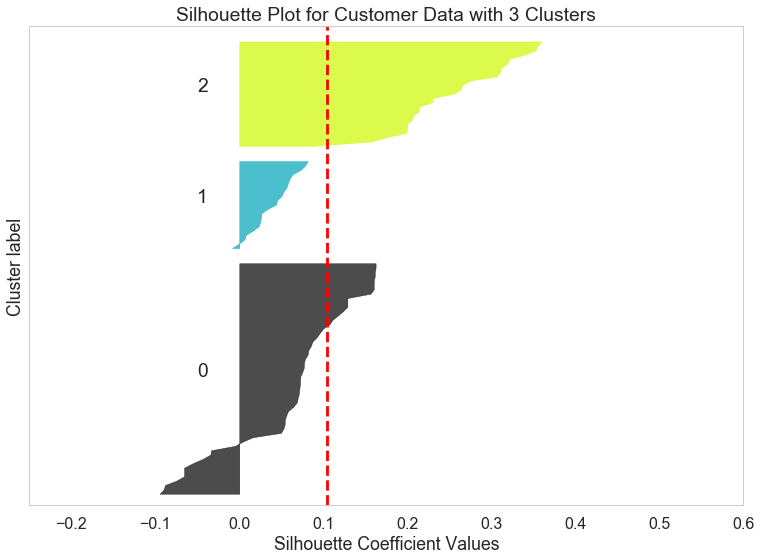

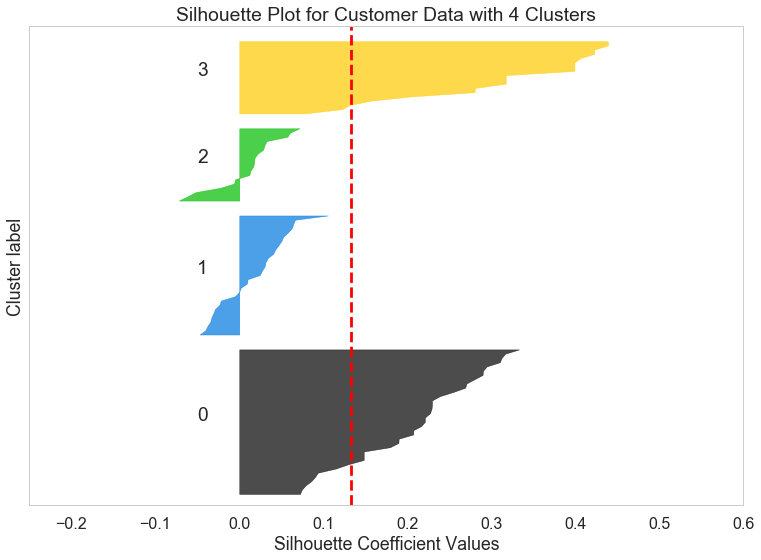

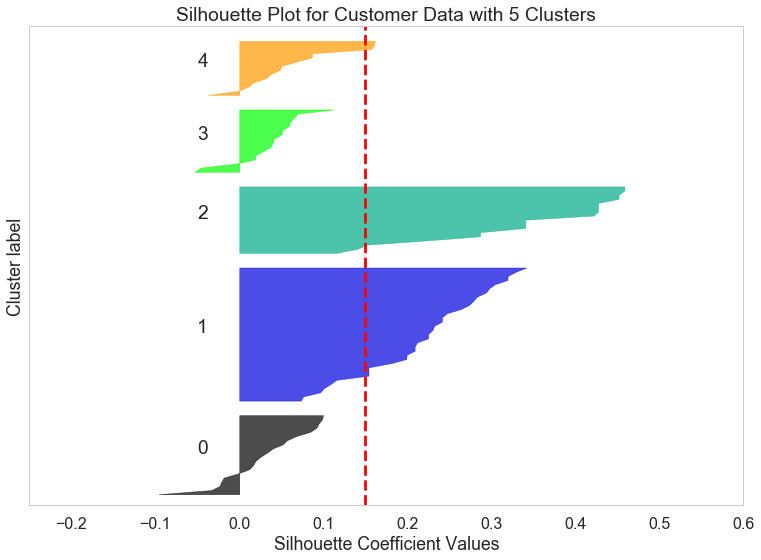

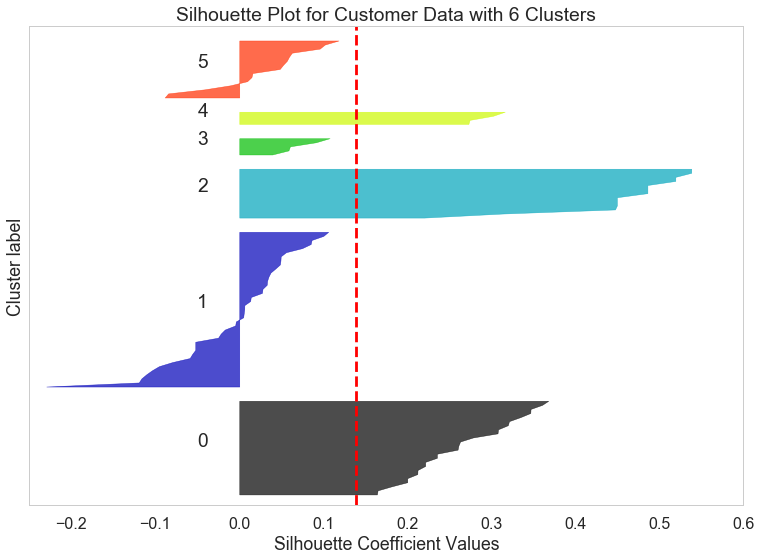

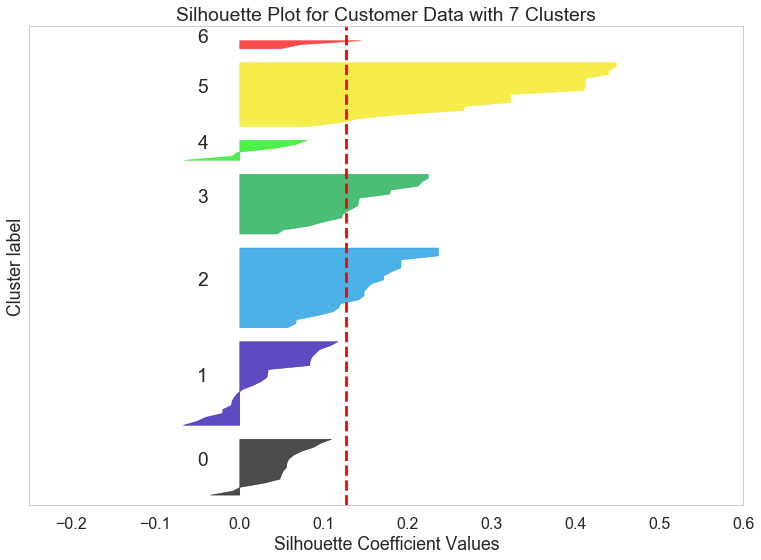

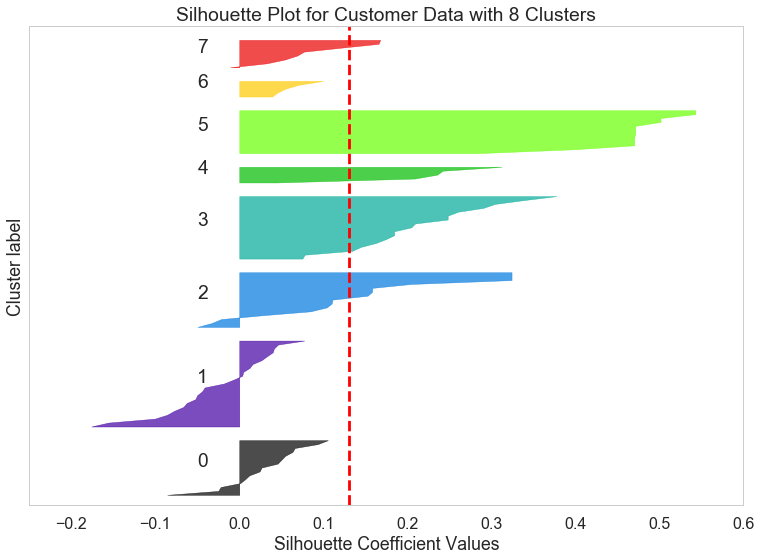

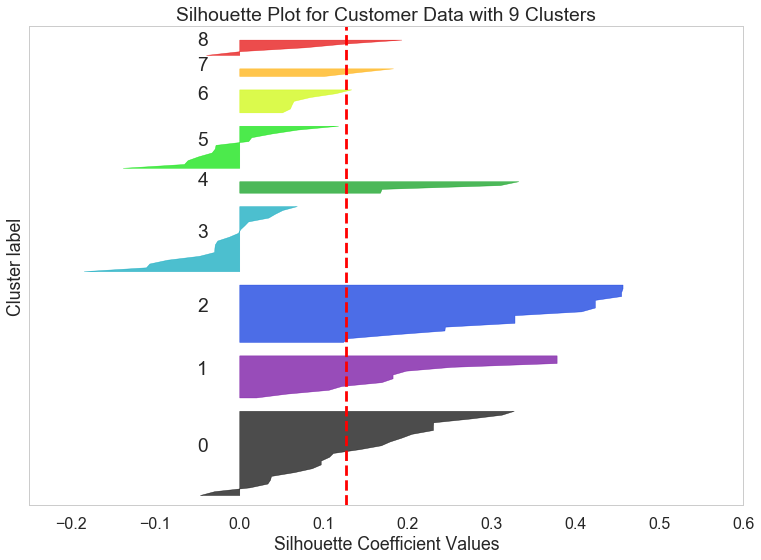

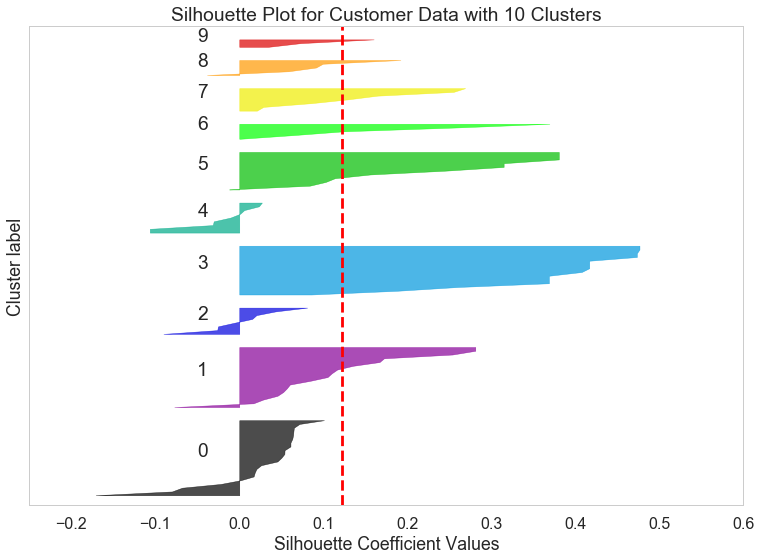

In [10]:
# Your turn.

from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# the linked document on selecting K using silhoutte_score has a very nice loop for making multiple figures
# I am basing my approach on that loop

for k in k_range:
    
    ##
    # build the KMeans model and obtain cluster labels
    ##
    
    # a random state of 5 is used for consistency with the above results
    clusterer = KMeans( n_clusters = k, random_state = 5 )
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # get silhouette score and print result
    slht_avg = silhouette_score(x_cols, cluster_labels)
    print("For k = %.0f, the average silhouette score is %.4f" % (k, slht_avg))
    
    # get silhouette scores for each observation
    obs_slht_vals = silhouette_samples(x_cols, cluster_labels)
    
    ##
    # build graphs for the distances in each cluster
    ##
    
    # build framework for graphs
    fig, ax = plt.subplots(1,1)
    ax.set_xlim([-0.25, 0.6])
    ax.set_ylim([0, len(x_cols) + (k + 1) * 2.5])
    
    # build graphs by building data
    
    y_lower = 2.5                                              # starting lower bound; will be updated as the graph is built
    for i in range(k):
        # obtain and sort data for graphing
        cluster_slht_vals = obs_slht_vals[cluster_labels == i] # cluster-specific silhouette values for graphing
        cluster_slht_vals.sort()                               # sort in default (ascending) order
        
        # set graph space for the cluster and a color
        cluster_size = cluster_slht_vals.shape[0]              # find out how many obs in the cluster
        y_upper = y_lower + cluster_size                       # set an upper bound based for the individual cluster
        color = cm.spectral(float(i) / k)                      # set a color for the plot of distances in this cluster
        
        # fill graph with data
        ax.fill_betweenx(y = np.arange(y_lower, y_upper), x1 = 0, x2 = cluster_slht_vals,
                    facecolor = color, edgecolor = color, alpha = 0.7)
        
        # label axes and set for next cluster
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))   # label plot areas for cluster
        y_lower = y_upper + 2.5                                # provide space between plots for each cluster
          
    # layout griding system for the plot
    ax.grid(False)                                             # remove grid lines
    ax.axvline(x = slht_avg, color = "red", linestyle = "--")  # add a line for silhouette average
    ax.set_yticks([])                                          # remove y ticks
    
    # add figure labels
    ax.set_title("Silhouette Plot for Customer Data with %.0f Clusters" % k)
    ax.set_ylabel("Cluster label")
    ax.set_xlabel("Silhouette Coefficient Values")

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

### Checkup Exercise Set IV

**Exercise:** Use PCA to plot your clusters:

* Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
* Create a data frame with the following fields:
    * customer name
    * cluster id the customer belongs to
    * the two PCA components (label them `x` and `y`)
* Plot a scatterplot of the `x` vs `y` columns
* Color-code points differently based on cluster ID
* How do the clusters look? 
* Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?

**Exercise:** Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [ ]:
#your turn

from sklearn.decomposition import PCA

#### Build Dataset

In [46]:
# run the PCA with 2 components
pca = PCA(n_components = 2)
wine_factors = np.matrix(pca.fit_transform(x_cols))
wine_factors_df = pd.DataFrame(wine_factors)
wine_factors_df.columns = ['x','y']

# build the dataset

# initialize dataset with names and factors
wine_clusters = pd.DataFrame(customer_offer.iloc[:,0])
wine_clusters['x'], wine_clusters['y'] = wine_factors_df['x'], wine_factors_df['y']

# add cluster labels using the same k-range as used above
for k in k_range:
    
    # calculate cluster labels
    # a random state of 5 is used for consistency with the above results
    clusterer = KMeans( n_clusters = k, random_state = 5 )
    cluster_labels = clusterer.fit_predict(wine_factors)
    
    # append labels to dataframe
    wine_clusters[str('clusters_' + str(k))] = cluster_labels

wine_clusters.head()

customer_name         x         y  clusters_2  clusters_3  clusters_4  \
0         Adams  1.014908  0.157764           1           1           0   
1         Allen -0.313043  0.019268           0           0           3   
2      Anderson -0.451462  1.008114           0           2           2   
3        Bailey  0.700551  0.006002           1           1           0   
4         Baker  0.072574 -0.494352           0           0           1   

   clusters_5  clusters_6  clusters_7  clusters_8  clusters_9  clusters_10  
0           4           1           3           3           3            1  
1           3           0           4           5           5            0  
2           2           2           1           2           1            3  
3           1           3           6           1           6            9  
4           0           4           2           6           8            7

#### Build Scatterplots

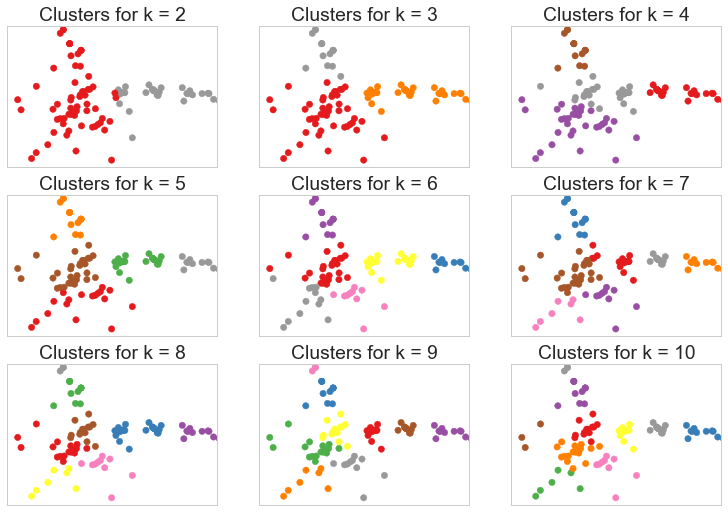

In [77]:
# set x and y limits for the plots
# will use range, +/- 5% of the range for min, max
x_range = np.ptp(wine_clusters['x'])
x_min, x_max = np.min(wine_clusters['x']) - 0.05 * x_range, np.max(wine_clusters['x']) - 0.05 * x_range

y_range = np.ptp(wine_clusters['y'])
y_min, y_max = np.min(wine_clusters['y']) - 0.05 * y_range, np.max(wine_clusters['y']) - 0.05 * y_range

# setup figure and fill with data
fig = plt.figure()
for k in k_range:    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k-1)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # fill data in the scatterplots
    plt.scatter(x = wine_clusters['x'], y = wine_clusters['y'], s = 40,
                c = wine_clusters.iloc[:,k + 1], cmap = 'Set1')
    ax.set_title('Clusters for k = ' + str(k))    

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

_Reply:_ Based on the scatterplots, I would recommend using either $K$ = 3 or $K$ = 5. These two appear to have the closest matches to gaps in the scatterplot without overly splitting tight groupings.

The earlier clusters proved inconclusive. The silhouette scores show this most clearly; a score greater than 0.25 is necessary to conclude any structure exists, but no score exceeded 0.15. The patterns in response to individual promotions is too varied and too intermixed to find any coherent grouping. But, if we first group together the different promotions, and then group the buyers, we begin to see some potential structure. Grouping the promotions is done through the PCA. Without the PCA, each promotion is viewed as independent from the others. With the PCA the promotions are grouped grouped together, allowing us to see a buyer's response, or lack of response to a promotion, as part of a pattern of behavior that includes multiple promotions. This grouping gave us greater insight into buyer behavior while also showing how data reduction can reveal information hidden in higher dimension data by restructing the data. What I have not done is to look at how many buyers in each group responded to which promotions. That would be important to understanding the content of each cluster and necessary for making specific business recommendations. It may also act as a test for whether or not the PCA has created an artificial structure by forcing the data into too few dimensions.

Without having tested the Gap Statistic method, I would recommend the use of silhouette scores as the best method for choosing $K$, in general. The Elbow Method and the scatterplots require subjective decisions while the silhouette scores provide a specific and clearly interpretatable result. The scatterplots following a PCA did produce a more clearly interpretable figure than the Elbow Method plot, but requires that the PCA search for only 2 component factors. This is not always the appropriate number of factors to found in a dataset. Using the silhouette score, or even the Elbow Method, following a PCA would provide additional information and allow the PCA to find more than 2 factors -- or allow the PCA to confirm that the best result is 2 factors.

As is usually the case with statistical approaches, it is not obvious that any one method is always best, with the best practice often being to try and compare the results from multiple approaches. In the case of clustering, it seems that these methods progressed from the simplest to the most complicated. A good practice would likely apply each method in turn, adding complexity and evaluating performance at each step, stopping as soon as a clear result emerges or a lack of result across all methods argues strongly that no structure exists in the data.

### Exercise Set V

As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?

**Exercise:** Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?

An unbound PCA produces 31 factors.


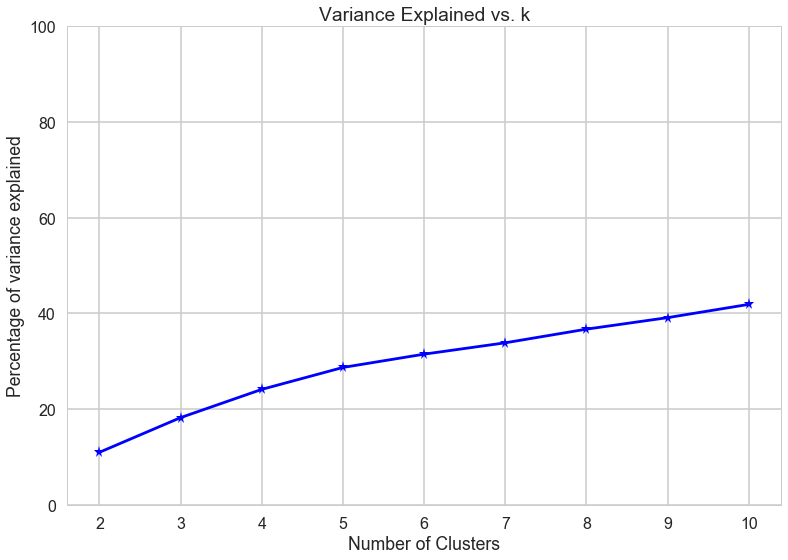

In [95]:
#your turn

"""
The repository from Sarah Guido, referenced in the optional video provides an example of this
and I will rely heavily on her code to build this plot.
"""

# Initialize a new PCA model with a default number of components.
# I'm commenting the provided code out; much of this code is redundant or must be changed.
# To clarify my work, I'm retaining the provided code as a comment and starting over.
"""
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

"""
# Do the rest on your own :)

from scipy.spatial.distance import cdist, pdist

pca = PCA()
factors = pca.fit_transform(x_cols)
print("An unbound PCA produces %s factors." % str(len(factors[1])))

# reminder: k_range = range(2,11)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k, random_state = 5).fit(factors) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(factors, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(factors)**2)/factors.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

_Reply:_ The plot has no clear elbow; this is an inconclusive result. I would not attempt to pick an optimal result for $K$. If forced to pick, I would probably pick 5 clusters. This is not proof, but I suspect that the lack of real result is a product of the high dimensionality of the data. My conclusion is that an unbounded PCA did not produce a useful result. The PCA resulted in 31 factors while the original data had 32 factors. This is hardly a reduction in dimensionality and, to my mind, indicative of data that really doesn't have any underlying structure. I further conclude that the results shown by the earlier PCA created a structure in the data that is not there; if there were some structure, then the unbounded PCA would have produced a useful data reduction, and so any structure observed is an artifact of the method and not a real result.


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
# Your turn